# TabPFN

Main idea: transformer for a small tabular data, based on Prior-Data Fitted Networks (PFN). PFN uses Bayesian inference given any prior one can sample from and approximate the posterior predictive distribution (PPD) directly. PFN can simply design a dataset-generating algorithm that encodes the desired prior.

Basically, TabPFN on the offline stage is trained on synthetic datasets and learns to determine from which distribution φ<sub>i</sub>: X<sub>i</sub> ~ y<sub>i</sub> each object was sampled. On the online stage TabPFN gets data from the real dataset, represents posterior distribution from which this dataset was sampled as mix of prior distributions φ<sub>i</sub> it was trained, weighted by their likelihood. Then it fits it's hyperparameters according to that posterior data distribution and makes a predictions.


## TabPFN: result

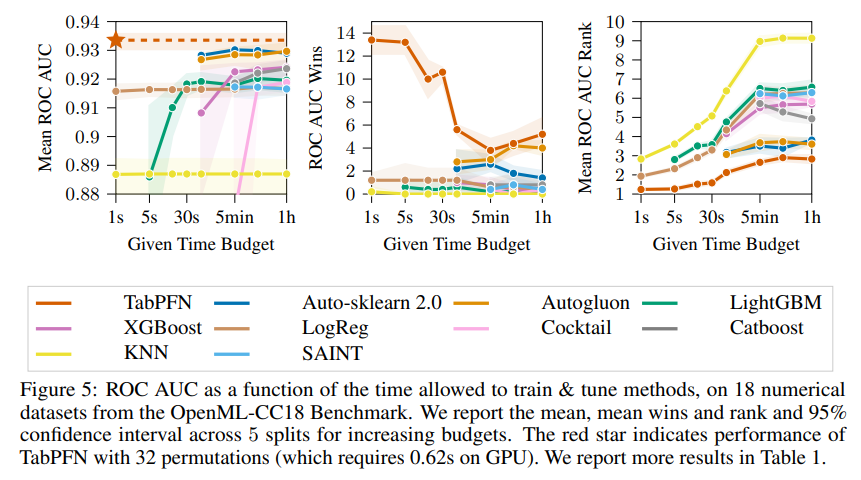

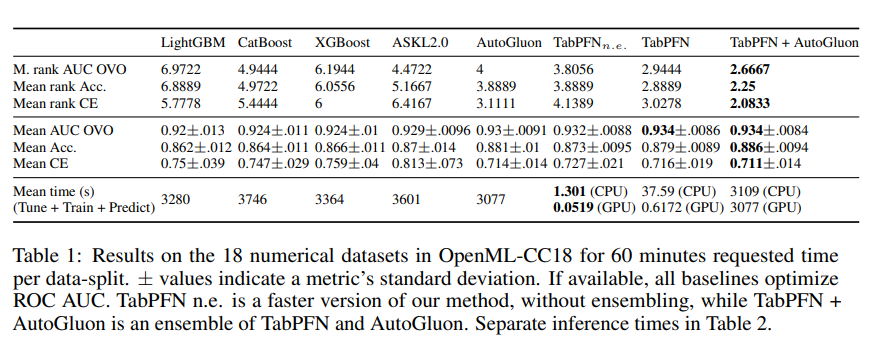

## More detailed explanation of TabPFN

We design a prior based on Bayesian Neural Networks (BNN) and Structural Causal Models (SCM) to model complex feature dependencies and potential causal mechanisms underlying tabular data. Our prior is defined via parametric distributions, e.g., a log-scaled uniform distribution for the average number of nodes in data-generating SCMs. The resulting PPD implicitly models uncertainty over all possible data-generating mechanisms, weighting them by their likelihood given the data and their prior probability. Thus, the PPD corresponds to an infinitely large ensemble of data-generating mechanisms, i.e., instantiations of SCMs and BNNs. We learn to approximate this complex PPD in a single forward-pass, requiring no cross-validation or model selection.

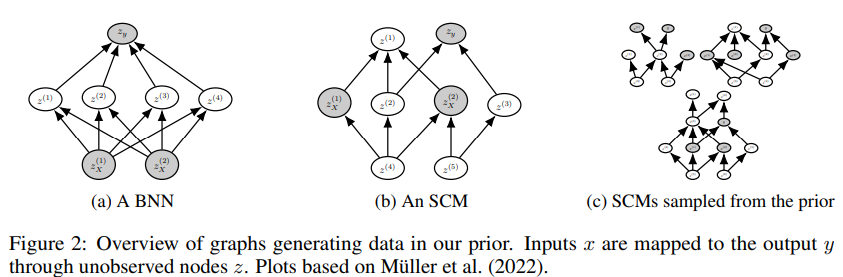

### How Bayesian inference works

In the Bayesian framework for supervised learning, the prior defines a space of hypotheses **Φ** on the relationship of a set of inputs **x** to the output labels **y**. Each hypothesis **φ** ∈ **Φ** can be seen as a mechanism that generates a data distribution from which we can draw samples forming a dataset. In practice, a dataset comprises training data with observed labels and test data where labels are missing or held out. The PPD for a test sample **x<sub>test</sub>** specifies the distribution of its label **p(·|x<sub>test</sub>, D<sub>train</sub>)**, which is conditioned on the set of training samples **D<sub>train</sub> := {(x<sub>1</sub>, y<sub>1</sub>), . . . , (x<sub>n</sub>, y<sub>n</sub>)}**. The PPD can be obtained by integration over the space of hypotheses **Φ**, where the weight of a hypothesis **φ** ∈ **Φ** is determined by its prior probability **p(φ)** and the likelihood **p(D|φ)** of the data D given **φ**:

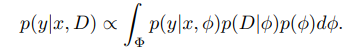

### Prior-fitting

Prior-fitting is the training of a PFN to approximate the PPD and thus do Bayesian prediction. We implement it with a prior which is specified by a prior sampling scheme of the form **p(D) = E<sub>φ∼p(φ)</sub>[p(D|φ)]**, which first samples hypotheses (generating mechanisms) with φ ∼ p(φ) and then synthetic datasets with **D ∼ p(D|φ)**. We repeatedly sample such synthetic datasets **D := (x<sub>i</sub>, y<sub>i</sub>) <sub>i∈{1,...,n}</sub>** and optimize the PFN's parameters **θ** to make predictions for **D<sub>test</sub> ⊂ D**, conditioned on the rest of the dataset **D<sub>train</sub> = D \ D<sub>test</sub>**. The loss of the PFN training thus is the cross-entropy on held-out examples of synthetic datasets. For a single test point **{(x<sub>test</sub>, y<sub>test</sub>)} = D<sub>test</sub>**, the training loss can be written as

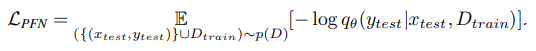

Minimizing this loss approximates the true Bayesian posterior predictive distribution.

### Real-World Inference 

During inference, the trained model is applied to unseen real-world datasets. For a novel dataset with training samples **D<sub>train</sub>** and test features **x<sub>test</sub>**, feeding **<D<sub>train</sub>**, **x<sub>test</sub>>** as an input to the model trained above yields the PPD **q<sub>θ</sub>(y|x<sub>test</sub>, D<sub>train</sub>)** in a single forward-pass. The PPD class probabilities are then used as predictions for our real-world task.

We visualize this in the image below:

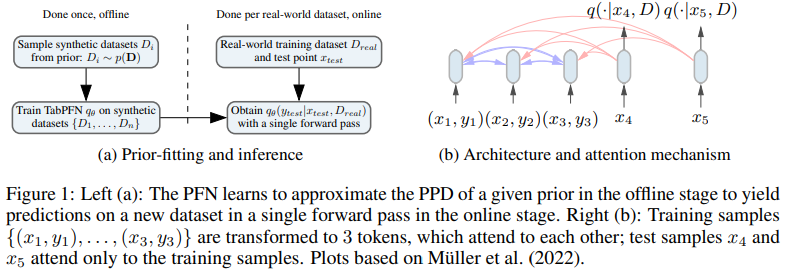

### Inference

During inference, the TabPFN approximates the PPD for our dataset prior, i.e., it approximates the marginal predictions across our spaces of SCMs and BNNs, including a bias towards simple and causal explanations for the data. In our experiments, we present predictions for a single forward pass of our TabPFN, as well as predictions that ensemble 32 forward passes of datasets modified by a power transformation (applied with probability 0.5) and rotating the indices of feature columns and class labels.